In [2]:
import sys
import os

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)

print("Project root added to path:", project_root)

Project root added to path: /Users/krishna/Desktop/NIRANJAN/rl-derivative_hedging


In [3]:
%pip install yfinance
%pip install scipy
%pip install matplotlib
%pip install stable-baselines3 gymnasium

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
data = yf.download("SPY", start="2018-01-01", end="2023-01-01")
print(data.head())

/Users/krishna/Desktop/NIRANJAN/rl-derivative_hedging/.venv/lib/python3.13/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker             SPY         SPY         SPY         SPY       SPY
Date                                                                
2018-01-02  237.208221  237.243532  235.999105  236.387438  86655700
2018-01-03  238.708649  238.858697  237.375960  237.375960  90070400
2018-01-04  239.714737  240.200166  238.770408  239.352907  80636400
2018-01-05  241.312180  241.435725  240.014801  240.509038  83524000
2018-01-08  241.753494  241.912350  240.923877  241.215113  57319200


In [5]:
print(data.shape)
print(data.columns)

(1259, 5)
MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [6]:
from pricing.black_scholes import bs_call_price, bs_delta, bs_gamma

S = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2

print("Call Price:", bs_call_price(S, K, T, r, sigma))
print("Delta:", bs_delta(S, K, T, r, sigma))
print("Gamma:", bs_gamma(S, K, T, r, sigma))

Call Price: 10.450583572185565
Delta: 0.6368306511756191
Gamma: 0.018762017345846895


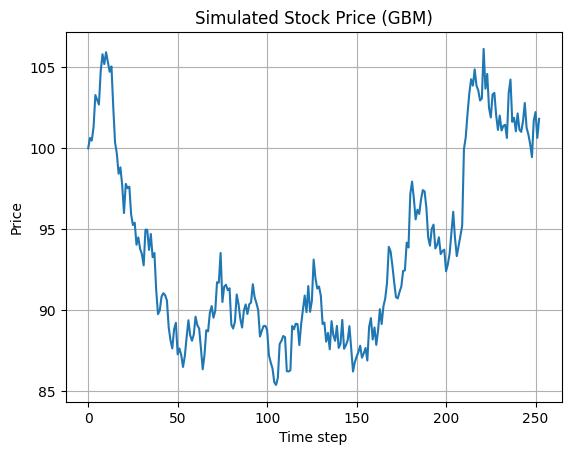

In [7]:
from simulator.gbm import simulate_gbm
import matplotlib.pyplot as plt

prices = simulate_gbm(
    S0=100,
    mu=0.05,
    sigma=0.2,
    T=1.0,
    steps=252,
    seed=42
)

plt.plot(prices)
plt.title("Simulated Stock Price (GBM)")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.grid(True)
plt.show()

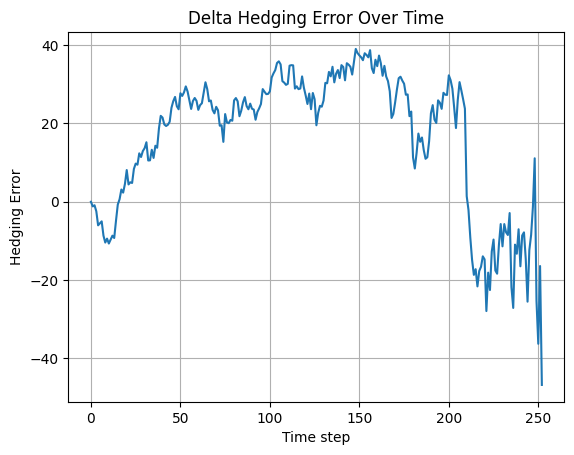

In [8]:
from simulator.gbm import simulate_gbm
from benchmarks.delta_hedging import delta_hedge
import matplotlib.pyplot as plt

# Simulate stock prices
prices = simulate_gbm(
    S0=100,
    mu=0.05,
    sigma=0.2,
    T=1.0,
    steps=252,
    seed=42
)

# Run delta hedging
result = delta_hedge(
    prices=prices,
    K=100,
    r=0.05,
    sigma=0.2,
    T=1.0
)

# Plot hedging error
plt.plot(result["hedging_error"])
plt.title("Delta Hedging Error Over Time")
plt.xlabel("Time step")
plt.ylabel("Hedging Error")
plt.grid(True)
plt.show()

In [9]:
from env.hedging_env import HedgingEnv
env = HedgingEnv()

In [10]:
obs, _ = env.reset()

print("Initial state:", obs)
print("=" * 50)

for step in range(3):
    action = env.action_space.sample()  # RANDOM action
    obs, reward, done, _, _ = env.step(action)

    print(f"Step {step}")
    print("Action taken:", action)
    print("Reward received:", reward)
    print("New state:", obs)
    print("-" * 50)

    if done:
        break

Initial state: [0.         0.6368306  0.01876202 1.         0.2        0.        ]
Step 0
Action taken: [-0.8132809]
Reward received: -1.6057404423708543
New state: [-0.00807828  0.6212758   0.01921059  0.99603176  0.2        -0.8132809 ]
--------------------------------------------------
Step 1
Action taken: [-0.4890328]
Reward received: -1.4763901885859625
New state: [-0.01409643  0.60943425  0.019542    0.99206346  0.2        -1.3023137 ]
--------------------------------------------------
Step 2
Action taken: [-0.67106974]
Reward received: -3.8003902099418196
New state: [-0.02144085  0.594859    0.01991949  0.9880952   0.2        -1.9733834 ]
--------------------------------------------------


In [11]:
from stable_baselines3 import PPO
from env.hedging_env import HedgingEnv

env = HedgingEnv()

model = PPO(
    policy="MlpPolicy",
    env=env,
    verbose=1
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [12]:
model.learn(total_timesteps=1000)

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 252       |
|    ep_rew_mean     | -2.79e+04 |
| time/              |           |
|    fps             | 1732      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------


In [13]:
obs, _ = env.reset()

print("=== PPO Agent Acting ===")

for step in range(5):
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)

    print(f"Step {step}")
    print("Action:", action)
    print("Reward:", reward)
    print("State:", obs)
    print("-" * 40)

    if done:
        break

=== PPO Agent Acting ===
Step 0
Action: [0.3048674]
Reward: -0.021829553312082167
State: [0.00602024 0.64782906 0.01848677 0.99603176 0.2        0.3048674 ]
----------------------------------------
Step 1
Action: [0.9928759]
Reward: -0.0670914247922702
State: [0.00806489 0.65139663 0.0184176  0.99206346 0.2        1.2977433 ]
----------------------------------------
Step 2
Action: [0.7626604]
Reward: -0.1601742247560518
State: [0.00452742 0.6445633  0.01864992 0.9880952  0.2        2.0604036 ]
----------------------------------------
Step 3
Action: [-0.46578082]
Reward: -0.59608623439746
State: [-0.00428156  0.62764835  0.01915087  0.984127    0.2         1.5946229 ]
----------------------------------------
Step 4
Action: [0.8669615]
Reward: -23.638501871517647
State: [0.02173874 0.6759124  0.01776556 0.98015875 0.2        2.4615843 ]
----------------------------------------


In [14]:
import numpy as np
from simulator.gbm import simulate_gbm

S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1.0
steps = 252

prices = simulate_gbm(
    S0=S0,
    mu=r,
    sigma=sigma,
    T=T,
    steps=steps,
    seed=42
)

In [15]:
from benchmarks.delta_hedging import delta_hedge

delta_result = delta_hedge(
    prices=prices,
    K=K,
    r=r,
    sigma=sigma,
    T=T
)

delta_error = delta_result["hedging_error"]

In [16]:
from env.hedging_env import HedgingEnv

env = HedgingEnv(
    S0=S0,
    K=K,
    r=r,
    sigma=sigma,
    T=T,
    steps=steps
)

obs, _ = env.reset()
random_errors = []

for _ in range(steps):
    action = env.action_space.sample()
    obs, reward, done, _, _ = env.step(action)
    random_errors.append(-reward)  # proxy for instability
    if done:
        break

random_errors = np.array(random_errors)

In [17]:
obs, _ = env.reset()
ppo_errors = []

for _ in range(steps):
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    ppo_errors.append(-reward)
    if done:
        break

ppo_errors = np.array(ppo_errors)

In [18]:
delta_abs = np.abs(delta_error)
random_abs = np.sqrt(random_errors)   # undo squaring
ppo_abs = np.sqrt(ppo_errors)



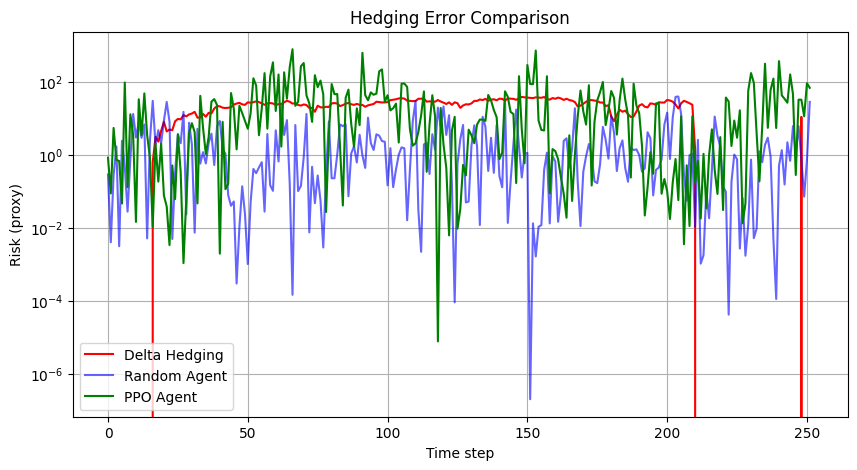

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(delta_error, label="Delta Hedging", color = "red")
plt.plot(random_errors, label="Random Agent", alpha=0.6, color = "blue")
plt.plot(ppo_errors, label="PPO Agent", color = "green")
plt.legend()
plt.title("Hedging Error Comparison")
plt.xlabel("Time step")
plt.ylabel("Risk (proxy)")
plt.grid(True)
plt.yscale("log")
plt.show()

In [20]:
def risk_summary(x):
    return {
        "Mean": np.mean(x),
        "Std": np.std(x),
        "Max": np.max(x)
    }

print("Random:", risk_summary(random_errors))
print("Delta :", risk_summary(delta_error))
print("PPO   :", risk_summary(ppo_errors))

Random: {'Mean': np.float64(3.2919978158231804), 'Std': np.float64(6.37779231605119), 'Max': np.float64(39.951200823021)}
Delta : {'Mean': np.float64(16.35679265318743), 'Std': np.float64(17.800816143671618), 'Max': np.float64(39.01989480721396)}
PPO   : {'Mean': np.float64(42.33544004275239), 'Std': np.float64(96.84223970395534), 'Max': np.float64(788.8212457240589)}


In [27]:
from env.hedging_env import HedgingEnv
env = HedgingEnv()
obs, _ = env.reset()
model.learn(total_timesteps=5_000)
print(obs)

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 252       |
|    ep_rew_mean     | -6.96e+03 |
| time/              |           |
|    fps             | 2411      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 252         |
|    ep_rew_mean          | -4.54e+03   |
| time/                   |             |
|    fps                  | 1896        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008590255 |
|    clip_fraction        | 0.0936      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.000236    |
|    learning_rate  

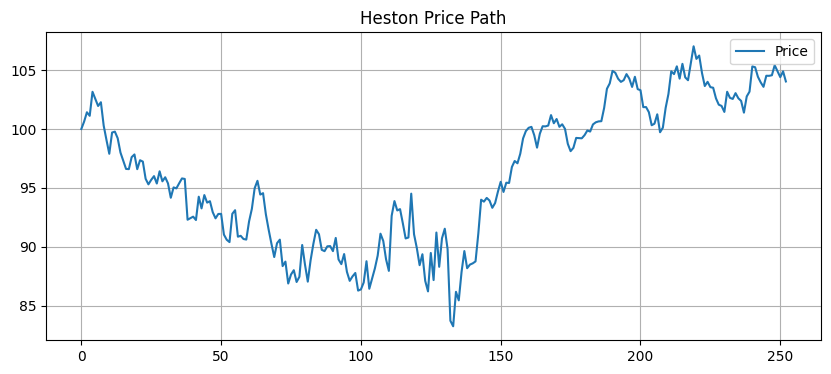

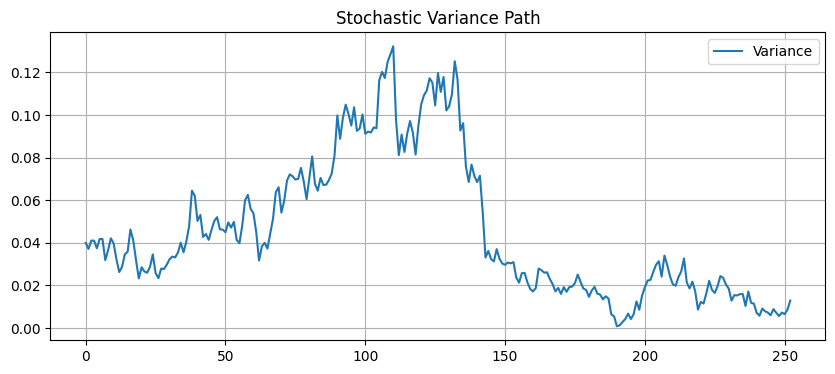

In [28]:
from simulator.heston import simulate_heston
prices, vars = simulate_heston(
    S0=100,
    v0=0.04,
    rho=-0.7,
    kappa=2.0,
    theta=0.04,
    sigma=0.5,
    T=1.0,
    steps=252,
    seed=42,
)

plt.figure(figsize=(10,4))
plt.plot(prices, label="Price")
plt.title("Heston Price Path")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(vars, label="Variance")
plt.title("Stochastic Variance Path")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
env = HedgingEnv(use_heston=True)
obs, _ = env.reset()
print(obs)

[0.         0.6368306  0.01876202 1.         0.2        0.        ]


In [30]:
prices, _ = simulate_heston(
    S0=100,
    v0=0.04,
    rho=-0.7,
    kappa=2.0,
    theta=0.04,
    sigma=0.5,
    T=1.0,
    steps=252,
    seed=42,
)

delta_heston = delta_hedge(
    prices=prices,
    K=100,
    r=0.05,
    sigma=0.2,  # WRONG volatility on purpose
    T=1.0,
)

delta_heston_abs = np.abs(delta_heston["hedging_error"])

In [31]:
env_heston = HedgingEnv(use_heston=True)

obs, _ = env_heston.reset()
ppo_heston = []

for _ in range(252):
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env_heston.step(action)
    ppo_heston.append(np.sqrt(-reward))
    if done:
        break

ppo_heston = np.array(ppo_heston)

“Hedging under Stochastic Volatility (Heston)”

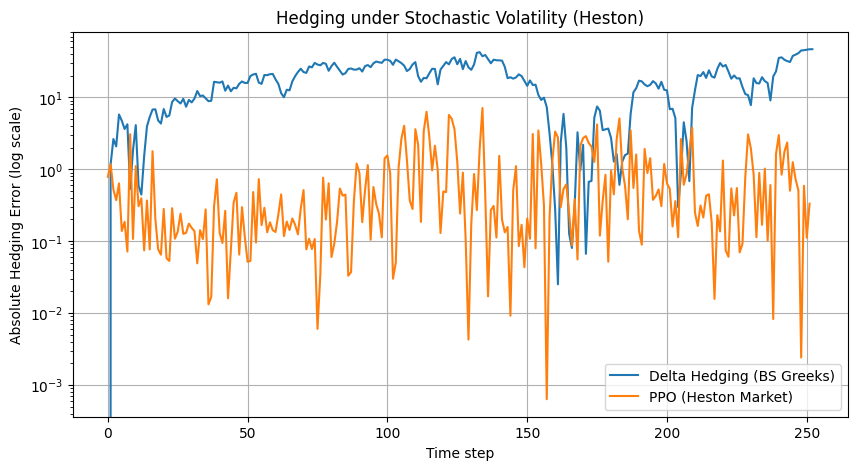

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(delta_heston_abs, label="Delta Hedging (BS Greeks)")
plt.plot(ppo_heston, label="PPO (Heston Market)")
plt.yscale("log")
plt.legend()
plt.title("Hedging under Stochastic Volatility (Heston)")
plt.xlabel("Time step")
plt.ylabel("Absolute Hedging Error (log scale)")
plt.grid(True)
plt.show()